# Convolutional Neural Net

In this workbook we'll apply a CNN to the image data that was generated in the previous workbook. This workbook is specific to the Low Frequency Spectrograms that were previously generated and is important for the purpose of our analysis as creating a lightweight version of our initial model could be more beneficial in some use cases.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import os
import json
import seaborn as sns
import tensorflow as tf
import random


from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,classification_report
from sklearn.preprocessing import normalize,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.compose import ColumnTransformer


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D,LeakyReLU
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

import librosa
import librosa.display

from scipy.stats import skew

### Importing Variables

In [13]:
with open('pickles/Y_low.pkl', 'rb') as f:
    Y_low = pickle.load(f)
    
with open('pickles/X_low.pkl', 'rb') as f:
    X_low = pickle.load(f)

In [14]:
len(X_low),len(Y_low)

(137133, 137133)

In [15]:
unique_values, counts = np.unique(Y_low, return_counts=True)

print("Unique values:", unique_values)
print("Value counts:", counts)

Unique values: [0 1]
Value counts: [88861 48272]


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_low, Y_low, test_size=0.2, random_state=42, stratify=Y_low)

### Data Generators

We'll feed our data into the model in batches of 32 so that all images aren’t loaded into the kernel at the same time. Within this function, we'll divide X_low by 255, to normalize the data.

This operation is split into two seperate generators to prevent data leakage from the training set into the validation set. Since the function has been seperated, each function will only be called when needed.

In [17]:
def train_data_generator(X_train, y_train, batch_size):
    num_train_samples = len(X_train)
    train_indices = np.arange(num_train_samples)
    np.random.shuffle(train_indices)

    while True:
        for start_idx in range(0, num_train_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_train_samples)
            batch_indices = train_indices[start_idx:end_idx]
            X_batch_train = X_train[batch_indices]
            y_batch_train = y_train[batch_indices]

            # Normalize the input data to [0, 1]
            X_batch_train = X_batch_train.astype('float32') / 255.0

            yield (X_batch_train, y_batch_train)

In [18]:
def val_data_generator(X_val, y_val, batch_size):
    num_val_samples = len(X_val)
    val_indices = np.arange(num_val_samples)
    np.random.shuffle(val_indices)

    while True:
        for start_idx_val in range(0, num_val_samples, batch_size):
            end_idx_val = min(start_idx_val + batch_size, num_val_samples)
            batch_indices_val = val_indices[start_idx_val:end_idx_val]
            X_batch_val = X_val[batch_indices_val]
            y_batch_val = y_val[batch_indices_val]

            # Normalize the input
            X_batch_val = X_batch_val.astype('float32') / 255.0

            yield (X_batch_val, y_batch_val)


# Define the batch size
batch_size = 32

train_generator = train_data_generator(X_train, y_train, batch_size)
val_generator = val_data_generator(X_val, y_val, batch_size)

### Instantiating the Model

Now we can instantiate the model. This time we'll use a slightly different architecture than our previous neural net, as we'll need additional regularization to account for the size of the dataset.

In [60]:
model = Sequential([
    Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.1), input_shape=(224, 224, 3)),
    MaxPooling2D(2),
    Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D(2),
    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(.2),
    Dense(2, activation='sigmoid')
])

In [61]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=6)

In [62]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100


2023-04-25 21:57:34.567151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3428/3428 [==============================] - ETA: 0s - loss: 0.3398 - accuracy: 0.5984

2023-04-25 22:05:43.944227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3428/3428 [==============================] - 575s 168ms/step - loss: 0.3398 - accuracy: 0.5984 - val_loss: 0.3396 - val_accuracy: 0.6971
Epoch 2/100
3428/3428 [==============================] - 706s 206ms/step - loss: 0.2840 - accuracy: 0.7275 - val_loss: 0.2750 - val_accuracy: 0.7315
Epoch 3/100
3428/3428 [==============================] - 696s 203ms/step - loss: 0.2717 - accuracy: 0.7421 - val_loss: 0.3106 - val_accuracy: 0.6144
Epoch 4/100
3428/3428 [==============================] - 691s 202ms/step - loss: 0.2676 - accuracy: 0.7540 - val_loss: 0.2839 - val_accuracy: 0.6490
Epoch 5/100
3428/3428 [==============================] - 688s 201ms/step - loss: 0.2633 - accuracy: 0.7637 - val_loss: 0.2423 - val_accuracy: 0.8439
Epoch 6/100
3428/3428 [==============================] - 539s 157ms/step - loss: 0.2624 - accuracy: 0.7738 - val_loss: 0.2237 - val_accuracy: 0.7760
Epoch 7/100
3428/3428 [==============================] - 573s 167ms/step - loss: 0.2593 - accuracy: 0.7741 - val_loss:

In [63]:
val_acc = history.history['val_accuracy'][-1]
print("Final validation accuracy:", val_acc)

Final validation accuracy: 0.9304623603820801


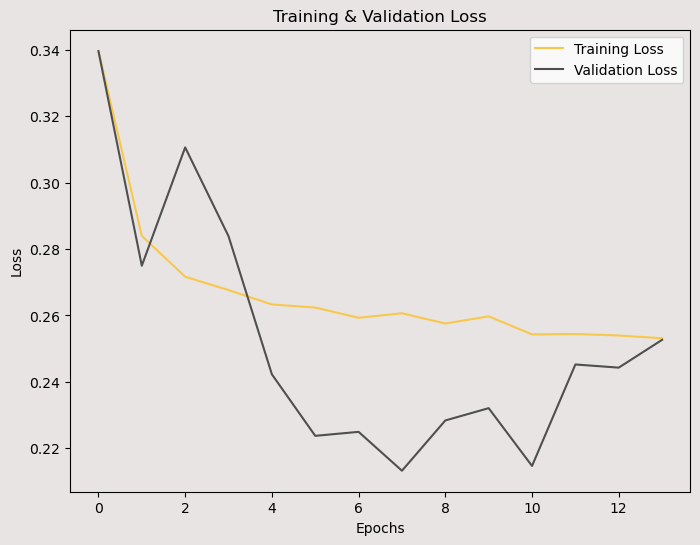

In [64]:
yellow = '#f8c84c'
grey = '#4F4F4F'
background = '#e8e4e4'

# Create the figure with the grey background
fig = plt.figure(figsize=(8, 6), facecolor=background)

# Set the background color of the plot area to grey
ax = fig.add_subplot(111)
ax.set_facecolor(background)

# Plot the data with the yellow-grey color scheme
plt.plot(history.epoch, history.history['loss'], color=yellow, label='Training Loss')
plt.plot(history.epoch, history.history['val_loss'], color=grey, label='Validation Loss')
plt.yscale('linear')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [ ]:
with open('pickles/model.pkl', 'wb') as f:
    pickle.dump(model, f)